# Plotting
Here you can explore the different possibilities that the hep_spt package offers for plotting.

In [1]:
%matplotlib inline
import hep_spt
hep_spt.set_style()
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import norm

## Plotting a (non)weighted sample
Use the function "errorbar_hist" to plot the same sample without and with weights. In the non-weighted case, we will ask for frequentist poissonian errors, so we will get asymmetric error bars for low values of the number of entries.

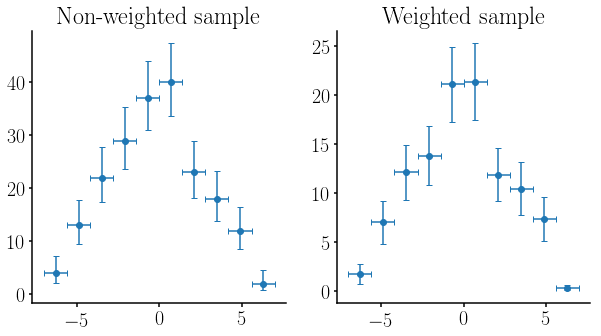

In [2]:
# Create a random sample
size = 200
smp  = np.random.normal(0, 3, size)
wgts = np.random.uniform(0, 1, size)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))

# Make the non-weighted plot
values, edges, ex, ey = hep_spt.errorbar_hist(smp, bins=10, range=(-7, 7), uncert='freq')
centers = (edges[1:] + edges[:-1])/2.

ax0.errorbar(centers, values, ey, ex, ls='none')
ax0.set_title('Non-weighted sample')

# Make the weighted plot
values, edges, ex, ey = hep_spt.errorbar_hist(smp, bins=10, range=(-7, 7), weights=wgts)
centers = (edges[1:] + edges[:-1])/2.

ax1.errorbar(centers, values, ey, ex, ls='none')
ax1.set_title('Weighted sample');

## Calculating the pull of a distribution
Sometimes we want to calculate the distance in terms of standard deviations from a curve to our measurements. This example creates a random sample of events following a normal distribution and overlies it with the original curve. The pull plot is shown below.

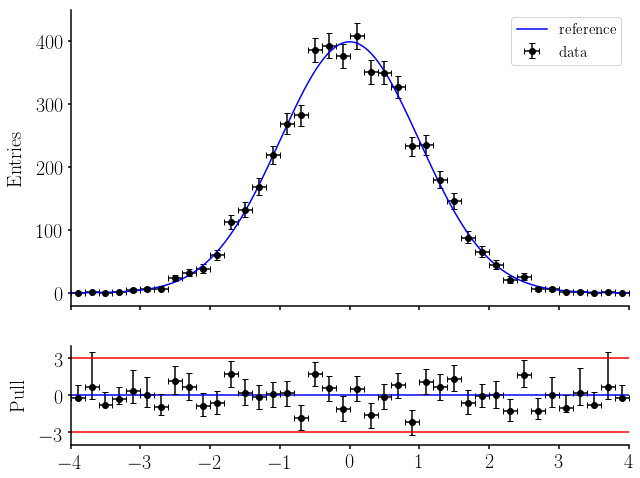

In [3]:
# Create the samples
size=5e3

sample = norm.rvs(size=int(size))

values, edges, ex, ey = hep_spt.errorbar_hist(sample, 40, range=(-4, 4), uncert='freq')
centers = (edges[1:] + edges[:-1])/2.

# Extract the PDF values in each center, and make the pull
ref  = norm.pdf(centers)
ref *= size/ref.sum()

pull, perr = hep_spt.pull(values, ey, ref)

# Make the reference to plot (with more points than just the centers of the bins)
rct, step = np.linspace(-4., 4., 1000, retstep=True)
pref = norm.pdf(rct)
pref = size*pref/pref.sum()*(edges[1] - edges[0])/step

fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True, gridspec_kw = {'height_ratios':[3, 1]}, figsize=(10, 8))

# Draw the histogram and the reference
ax0.errorbar(centers, values, ey, ex, color='k', ls='none', label='data')
ax0.plot(rct, pref, color='blue', marker='', label='reference')
ax0.set_xlim(-4., 4.)
ax0.set_ylabel('Entries')
ax0.legend(prop={'size': 15})

# Draw the pull and lines for -3, 0 and +3 standard deviations
add_pull_line = lambda v, c: ax1.plot([-4., 4.], [v, v], color=c, marker='')

add_pull_line(0, 'blue')
add_pull_line(-3, 'red')
add_pull_line(+3, 'red')

ax1.errorbar(centers, pull, perr, ex, color='k', ls='none')
ax1.set_ylim(-4, 4)
ax1.set_yticks([-3, 0, 3])
ax1.set_ylabel('Pull');

## Plotting efficiencies
Let's suppose we build two histograms from the same sample, one of them after having applied some  requirements. The first histogram will follow a gaussian distribution with center at 0 and standard deviation equal to 2, with 1000 entries. The second, with only 100 entries, will have the same center but the standard deviation will be 0.5. The efficiency plot would be calculated as follows:

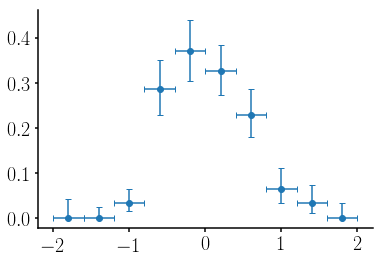

In [4]:
# Create a random sample
raw = np.random.normal(0, 2, 1000)
cut = np.random.normal(0, 0.5, 100)

# Create the histograms (we do not care about the errors for the moment). Note that the two
# histograms have the same number of bins and range.
h_raw, edges = np.histogram(raw, bins=10, range=(-2, 2))
h_cut, _     = np.histogram(cut, bins=10, range=(-2, 2))
centers = (edges[1:] + edges[:-1])/2.

ex = (edges[1:] - edges[:-1])/2.

# Calculate the efficiency and the errors
eff = h_cut.astype(float)/h_raw
ey  = hep_spt.cp_fu(h_cut, h_raw)

plt.errorbar(centers, eff, ey, ex, ls='none');

## Displaying the correlation between variables on a sample
The hep_spt package also provides a way to easily plot the correlation among the variables on a given sample. Let's create a sample composed by 5 variables, two being independent and three correlated with them, and plot the results. Note that we must specify the minimum and maximum values for the histogram in order to correctly assign the colors, making them universal across our plots.

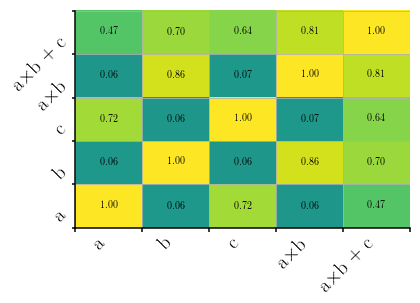

In [5]:
# Create a random sample
a   = np.random.uniform(0, 1, 1000)
b   = np.random.normal(0, 1, 1000)
c   = a + np.random.uniform(0, 1, 1000)
ab  = a*b
abc = ab + c
smp = np.array([a, b, c, ab, abc])

# Calculate the correlation
corr = np.corrcoef(smp)

# Plot the results
fig = plt.figure()

hep_spt.corr_hist2d(corr, ['a', 'b', 'c', 'a$\\times$b', 'a$\\times$b + c'], vmin=-1, vmax=+1)

## Plotting a 2D profile
When making 2D histograms, it is often useful to plot the profile in X or Y of the given distribution. This can be done as follows:

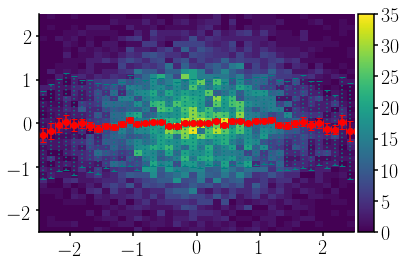

In [6]:
# Create a random sample
s = 10000
x = np.random.normal(0, 1, s)
y = np.random.normal(0, 1, s)

# Make the figure
fig = plt.figure()
ax  = fig.gca()

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

h, xe, ye, im = ax.hist2d(x, y, (40, 40), range=[(-2.5, +2.5), (-2.5, +2.5)])

# Calculate the profile together with the standard deviation of the sample
prof, std = hep_spt.profile(x, y, xe, std_type='sample')

eb = ax.errorbar(hep_spt.cfe(xe), prof, xerr=(xe[1] - xe[0])/2., yerr=std, color='teal', ls='none')
eb[-1][1].set_linestyle(':')

# Calculate the profile together with the default standard deviation (that of the mean)
prof, std = hep_spt.profile(x, y, xe)

ax.errorbar(hep_spt.cfe(xe), prof, xerr=(xe[1] - xe[0])/2., yerr=std, color='r', ls='none')

fig.colorbar(im, cax=cax, orientation='vertical');